# Introducción NLP con Pytorch

En este capítulo vamos a aprender a utilizar PyTorch para el enfoque del Lenguaje Natural (NLP). Pero para ello nos vamos a apoyar en cuatro librerías de Python enfocadas al NLP:

* <a href="https://www.nltk.org/" target="-blank"> nltk </a>

* <a href="https://radimrehurek.com/gensim/" target="_blank"> gensim </a>

* <a href="https://github.com/flairNLP/flair" target="_blank"> flair </a>

* <a href="https://huggingface.co/docs/datasets/v0.3.0/installation.html" target="_blank"> HuggingFace</a>

Para ello debemos proceeder a descargarlas:

In [1]:
#!pip uninstall gensim

In [2]:
#!pip install allennlp==0.9.0

In [3]:
#!pip install flair==0.8.0.post1 
# uses PyTorch 1.7.1

In [4]:
# HuggingFace
#!pip install transformers==4.5.1

In [5]:
#!pip install datasets==1.6.0

In [1]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, \
TensorDataset

In [2]:
from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text

In [8]:
#from stepbystep.v4 import StepByStep

In [6]:
#from seq2seq import *
import nltk
from nltk.tokenize import sent_tokenize
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from flair.data import Sentence
from flair.embeddings import ELMoEmbeddings, WordEmbeddings, \
TransformerWordEmbeddings, TransformerDocumentEmbeddings
from datasets import load_dataset, Split
from transformers import (
DataCollatorForLanguageModeling,
BertModel, BertTokenizer, BertForSequenceClassification,
DistilBertModel, DistilBertTokenizer,
DistilBertForSequenceClassification,
AutoModelForSequenceClassification,
AutoModel, AutoTokenizer, AutoModelForCausalLM,
Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\programas\Anaconda\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Francisco\AppData\Local\Temp\ipykernel_29632\2013528277.py", line 4, in <cell line: 4>
    import gensim
  File "D:\programas\Anaconda\envs\py39\lib\site-packages\gensim\__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
  File "D:\programas\Anaconda\envs\py39\lib\site-packages\gensim\corpora\__init__.py", line 6, in <module>
    from .indexedcorpus import IndexedCorpus  # noqa:F401 must appear before the other classes
  File "D:\programas\Anaconda\envs\py39\lib\site-packages\gensim\corpora\indexedcorpus.py", line 14, in <module>
    from gensim import interfaces, utils
  File "D:\programas\Anaconda\envs\py39\lib\site-packages\gensim\interfaces.py", line 19, in <module>
    from ge

"Down the Yellow Brick Rabbit Hole"

¿De dónde viene la frase de este título? Por un lado, podría se "en la madriguera del conejo", se podría pensar en "Las aventuras de Alicia en el país de las maravillas".

Por otro lado, si fuera "el camino de baldosas amarillas", podría ser "El maravilloso Mago de Oz". Pero no es ninguna de las dos cosas (¿o ¿o quizá ambas?). ¿Y si, en lugar de intentar adivinarlo nosotros mismos, entrenamos un modelo para clasificar las frases? Al fin y al cabo aprendizaje profundo.

Un poco de eso se trata en este tema.

El *Procesamiento del Lenguaje Natural (PLN)* consiste en entrenar modelos a partir de datos de texto.El campo es enorme y en este capítulo sólo vamos a ver su superficie. Empezaremos con la pregunta más obvia, "cómo convertir datos de texto en datos numéricos", y terminaremos usando un modelo preentrenado - nuestro famoso amigo teleñeco,BERT - para clasificar frases.

## Creando un Dataset.

Existen muchos conjuntos de datos de libre acceso para la NLP. Los textos suelen estar bien organizados en frases que se pueden fácilmente a un modelo preentrenado como BERT. 

Pero los textos que encontrarás en el mundo real no están bien organizados en frases. Tienes que organizarlos tú mismo.

Así pues, comenzaremos nuestro viaje de PNL siguiendo los pasos de Alicia y Dorothy, de <a href="https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1476" target="_blank"> "Las aventuras de Alicia en el país de las maravillas" </a> [155] de Lewis Carroll y <a href="https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1740" target="_blank">  "El maravilloso mago de Oz"</a>[156] de L. Frank Baum.


:::{note}
Ambos textos están disponibles y muchos más en <a href="https://ota.bodleian.ox.ac.uk/repository/xmlui/" target="_blank"> Oxford Text Archive (OTA) </a>
:::

Los enlaces directos a ambos textos son <a href="https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/1740/wizoz10-1740.txt" target="_blank"> alice28-1476.txt </a> (lo llamaremos ALICE_URL) y <a href="https://ota.bodleian.ox.ac.uk/repository/xmlui/bitstream/handle/20.500.12024/1740/wizoz10-1740.txt" target="_blank"> wizoz10-1740.txt </a> (lo llamaremos WIZARD_URL). 

Se puede descargar ambos archivos a una carpeta local utilizando el método de ayuda download_text (incluido en data_generation.nlp) (Ver antes la sentencia *from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text*):

In [10]:
# Crea una carpeta local llamada 'texts' en la misma carpeta
# que se tiene este jupyter 
localfolder = 'texts'
download_text(ALICE_URL, localfolder)
download_text(WIZARD_URL, localfolder)

Si abres estos archivos en un editor de texto, verás que hay mucha información al principio (y algo al final) que se ha  añadido al texto original del libro por razones legales. Tenemos que eliminar estos añadidos a los textos originales:

In [11]:
fname1 = os.path.join(localfolder, 'alice28-1476.txt')

with open(fname1, 'r') as f:
    alice = ''.join(f.readlines()[104:3704])

fname2 = os.path.join(localfolder, 'wizoz10-1740.txt')
with open(fname2, 'r') as f:
    wizard = ''.join(f.readlines()[310:5100])

Los textos reales de los libros están contenidos entre las líneas 105 y 3703 (recuerde la indexación basada en ceros de Python) y 309 y 5099, respectivamente. Por otra parte, estamos uniendo todas las líneas en una cadena de texto para cada libro porque vamos a organizar los textos organizar los textos resultantes en frases y, en un libro normal, **hay saltos de línea** en todas las frases.

Definitivamente no queremos hacerlo manualmente cada vez, ¿verdad?.Aunque sería más difícil eliminar automáticamente cualquier añadidos al texto original, al menos podemos automatizar la eliminación de las líneas adicionales estableciendo las líneas de inicio y fin reales de cada texto en un archivo de configuración (lines.cfg). Lo hacemos con el siguiente código

In [12]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""

bytes_written = open(
    os.path.join(localfolder, 'lines.cfg'), 'w'
).write(text_cfg)

POr lo tanto ahora en nuestra carpeta así creada, llamada texts, tenemos los tres ficheros:  alice28-1476.txt, 
lines.cfg, y wizoz10-1740.txt

## Tokenización.

```{index} Tokenización
```

El tipo de pieza  más común en NLP es una palabra. Por tanto, tokenizar un texto suele significar dividirlo en palabras utilizando el espacio en blanco como separador:

In [13]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

En la expresión anterior el problema puede surgir de cómo tratar la expresión *I´m* es decir, las contraciones.Contracciones como esa son bastante comunes, y tal vez usted quiere mantenerlos como tokens individuales. Pero también es posible que se quiera partir en sus dos componentes básicos, "I" y "am", de modo que la frase anterior tenga seis tokens en lugar de cinco. Por ahora, sólo sólo nos interesa la tokenización de frases, que,, como ya habrá adivinado, consiste en dividir un texto en palabras.

A continuación vamos a usar la sentencia *sent_tokenize* del paquete  NLTK para lograrlo en lugar de intentar crear nosotros mismos las reglas de división (NLTK es la biblioteca Natural Language Toolkit y es una de las herramientas más tradicionales para el manejo de tareas NLP):

In [14]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
corpus_alice = sent_tokenize(alice)
corpus_wizard = sent_tokenize(wizard)
len(corpus_alice), len(corpus_wizard)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Francisco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(1612, 2240)

Por lo tanto, el documento "Alice’s Adventures in Wonderland" tiene 1612 tokens y el otro 2240 tokens.

Un corpus es un conjunto estructurado de documentos. Pero  en esta definición se puede definir un documento como  una frase, un párrafo o incluso un libro entero. En nuestro caso, el documento es una frase, por lo que cada libro es en realidad un conjunto de frases, por lo que cada libro puede considerarse un corpus. El plural de corpus es en realidad corpora , así que tenemos un corpus.

Vemos una frase para el primer corpus

In [15]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

Observe que aún incluye los saltos de línea (\n) del texto original. El tokenizador de frases sólo se encarga de dividir las frases, no de limpiar los saltos de línea. 

Veamos una sentencia o frase para el segundo corpus:

In [16]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

Observamos que tampoco ha quitado las comillas del texto.

Nuestro conjunto de datos será una colección de archivos CSV, un archivo por cada libro.Cada archivo CSV contiene una frase por línea. Para conseguir esto vamos a hacer antes lo siguiente:

* Limpiar el carácter de salto de línea.

* defina un carácter de cita apropiado para "envolver" la frase de forma que las comas(,)  y puntos y comas (;) originales del texto inicial no se no se malinterpreten como caracteres de separación del archivo CSV.

* Añadir una segunda columna al archivo CSV (la primera es la propia frase) para identificar la fuente original de la frase, ya que vamos a concatenar y barajar las frases antes de entrenar un modelo con nuestro corpus

El carácter de escape "\\" es una buena opción para citar caracteres porque no está presente en ninguno de los libros (probablemente tendríamos que elegir otra cosa si nuestros libros fueran sobre codificación).

La siguiente función se encarga de limpiar, dividir y guardar las frases en un archivo CSV:

In [17]:
def sentence_tokenize(source, quote_char='\\', sep_char=',',
                      include_header=True, include_source=True, 
                      extensions=('txt'), **kwargs):
    nltk.download('punkt')
    # If source is a folder, goes through all files inside it
    # that match the desired extensions ('txt' by default)
    if os.path.isdir(source):
        filenames = [f for f in os.listdir(source)
                     if os.path.isfile(os.path.join(source, f)) and
                        os.path.splitext(f)[1][1:] in extensions]
    elif isinstance(source, str):
        filenames = [source]
    
    # If there is a configuration file, builds a dictionary with
    # the corresponding start and end lines of each text file
    config_file = os.path.join(source, 'lines.cfg')
    config = {}
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            rows = f.readlines()

        for r in rows[1:]:
            fname, start, end = r.strip().split(',')
            config.update({fname: (int(start), int(end))})
       
    new_fnames = []
    # For each file of text
    for fname in filenames:
        # If there's a start and end line for that file, use it
        try:
            start, end = config[fname]
        except KeyError:
            start = None
            end = None
            
        # Opens the file, slices the configures lines (if any)
        # cleans line breaks and uses the sentence tokenizer
        with open(os.path.join(source, fname), 'r') as f:
            contents = (''.join(f.readlines()[slice(start, end, None)])
                        .replace('\n', ' ').replace('\r', ''))
        corpus = sent_tokenize(contents, **kwargs)
        
        # Builds a CSV file containing tokenized sentences
        base = os.path.splitext(fname)[0]
        new_fname = f'{base}.sent.csv'
        new_fname = os.path.join(source, new_fname)
        with open(new_fname, 'w') as f:
            # Header of the file
            if include_header:
                if include_source:
                    f.write('sentence,source\n')
                else:
                    f.write('sentence\n')
            # Writes one line for each sentence
            for sentence in corpus:
                if include_source:
                    f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
                else:
                    f.write(f'{quote_char}{sentence}{quote_char}\n')
        new_fnames.append(new_fname)
        
    # Returns list of the newly generated CSV files
    return sorted(new_fnames)

Toma una carpeta de origen (o un único archivo) y recorre los archivos con las extensiones correctas (sólo .txt por defecto), eliminando líneas basándose en el archivo lines.cfg (si existe), aplicando a cada archivo el
tokenizer a cada archivo, y generando el correspondiente archivo CSV de sentencias utilizando los quote_char y sep_char configurados. También puede incluir_header e include_source en el archivo CSV.

Los archivos CSV se denominan como los archivos de texto correspondientes, eliminando la extensión original y añadiendo .sent.csv.  Veámoslo en acción: 

In [18]:
new_fnames = sentence_tokenize(localfolder)
new_fnames

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Francisco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['texts\\alice28-1476.sent.csv', 'texts\\wizoz10-1740.sent.csv']

Cada archivo CSV contiene las frases de un libro, y utilizaremos ambos para construir nuestro propio conjunto de datos.

## spacy.

```{index} Spacy
```

Por cierto, NLTK no es la única opción para la tokenización de frases: también es posible utilizar el <a href="https://spacy.io/api/sentencizer" target="_blank"> sentenciador </a> de spaCy para esta tarea. El siguiente fragmento muestra un ejemplo de  esto utilizando spaCy:

In [19]:
# conda install -c conda-forge spacy
# python -m spacy download en_core_web_sm
import spacy

nlp = spacy.blank("en")


nlp.add_pipe("sentencizer")
sentences = []
for doc in nlp.pipe(corpus_alice):
    sentences.extend(sent.text for sent in doc.sents)
    
len(sentences), sentences[2]

(1615,
 'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!')

Dado que spaCy utiliza un modelo diferente para tokenizar las frases, no es de extrañar que encontrara un número ligeramente diferente de frases en el texto.


## HuggingFace's Dataset

```{index} HuggingFace's
```

Utilizaremos <a href="https://huggingface.co/docs/datasets/index" target="_blank"> los conjuntos de datos de HuggingFace </a> en lugar de los normales de PyTorch.

El motivo de utilizar esta herramienta es básicamente doble:

* En primer lugar, vamos a utilizar los modelos preentrenados de HuggingFace (como BERT)  más adelante, por lo que es lógico optar por su implementación de conjuntos de datos. 

* En segundo lugar, hay muchos conjuntos de datos disponibles en su biblioteca, por lo que tiene sentido acostumbrarse a manejar datos de texto utilizando su implementación de conjuntos de datos.

Aunque estamos utilizando la clase Dataset de HuggingFace para construir nuestro propio conjunto de datos, sólo estamos utilizando una fracción de sus capacidades. Para una visión más detallada de lo que que tiene que ofrecer, asegúrese de revisar su extensa documentación:

* <a href="https://huggingface.co/docs/datasets/quickstart" target="_blank"> Quickstart </a>

*  <a href="https://huggingface.co/docs/datasets/access" target="_blank">Los conjuntos de datos</a>

* <a href="https://huggingface.co/docs/datasets/loading" target="_blank"> Cargando data set </a>

* <a href = "https://huggingface.co/datasets" target="_blank"> Lista de data set </a>



## Cargando datos.

Podemos utilizar HF's (a partir de ahora se abreviará  HuggingFace como HF) load_dataset para <a href="https://huggingface.co/docs/datasets/loading#from-local-files" target="_blank"> cargar desde archivos locales </a>:

In [1]:
from datasets import load_dataset, Split

In [21]:
dataset = load_dataset(path='csv',
    data_files=new_fnames,
    quotechar='\\',
    split=Split.TRAIN)

Using custom data configuration default-2fcccdf0f91f287e


Dataset csv downloaded and prepared to C:\Users\Francisco\.cache\huggingface\datasets\csv\default-2fcccdf0f91f287e\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


D:\programas\Anaconda\envs\py39\lib\site-packages\datasets\packaged_modules\csv\csv.py:92: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  csv_file_reader = pd.read_csv(
D:\programas\Anaconda\envs\py39\lib\site-packages\datasets\packaged_modules\csv\csv.py:92: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  csv_file_reader = pd.read_csv(
D:\programas\Anaconda\envs\py39\lib\site-packages\datasets\packaged_modules\csv\csv.py:92: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  csv_file_reader = pd.read_csv(
D:\programas\Anaconda\envs\py39\lib\site-packages\datasets\packaged_modules\csv\csv.py:92: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines 

El nombre del primer argumento (path) puede ser un poco engañoso... es en realidad la ruta de acceso al script de procesamiento del conjunto de datos, no los archivos reales.

Para cargar archivos CSV, podemos utilizar simplemente csv de HF como en el ejemplo anterior. La lista de archivos reales que contienen el texto (frases, en nuestro caso) en el argumento *data_files*. El argumento split se utiliza para designar la división que representa el conjunto de datos (Split.TRAIN, Split.VALIDATION o Split.TEST).

Además, el script CSV ofrece más opciones para controlar el análisis sintáctico y la lectura de los archivos CSV, como *quotechar, delimiter, column_names, skip_rows y quoting*. Para más detalles, <a href="https://huggingface.co/docs/datasets/loading#csv-files" target="_blank"> consulte la documentación sobre la carga de archivos CSV </a>.

También es posible cargar datos desde archivos <a herf="https://huggingface.co/docs/datasets/loading#from-a-python-dictionary" target="blanK"> JSON, archivos de texto, diccionarios Python y dataframes Pandas </a>.

In [22]:
dataset

Dataset({
    features: ['sentence', 'source'],
    num_rows: 3852
})

El conjunto de datos tiene muchos atributos, como features, num_columns y shape:

In [23]:
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

Nuestro conjunto de datos tiene dos columnas: sentence y source, y contiene 3.852 frases. 
Puede indexarse como una lista:

In [24]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

Esa es la tercera frase en nuestro conjunto de datos, y es de "Alice's  en el País de las Maravillas".

y sus columnas se pueden obtener como en un diccionario normal



In [25]:
dataset['source'][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

El *Dataset* tiene también muchos métodos, como por ejemplo *unique, map, filter, shuffle y train_test_split* y <a href="https://huggingface.co/docs/datasets/process" target="_blank"> muchos más que los puedes ver en este enlace</a>.

Pongamos en marcha algunos de estos métodos

In [26]:
dataset.unique('source')

['alice28-1476.txt', 'wizoz10-1740.txt']

Podemos utilizar el método *map* para crear nuevas columnas utilizando una función que  devuelve un diccionario con la nueva columna como clave:

In [27]:
def is_alice_label(row):
    is_alice = int(row['source'] == 'alice28-1476.txt')
    return {'labels': is_alice}

dataset = dataset.map(is_alice_label)

Parameter 'function'=<function is_alice_label at 0x00000210A18F1940> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Cada elemento del conjunto de datos es una fila correspondiente a un diccionario ({'frase': ..., 'fuente': ...}, en nuestro caso), por lo que la función tiene acceso a todas las columnas de una fila determinada. Nuestra función *is_alice_label*
comprueba la columna de origen y crea una columna de etiquetas. 

Si recuperamos la tercera frase de nuestro conjunto de datos una vez más, veremos ya la nueva columna:

In [28]:
dataset[2]

{'labels': 1,
 'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

Ahora que ya tenemos las etiquetas, podemos barajar el conjunto de datos y dividirlo en conjuntos de entrenamiento y prueba:

In [29]:
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'sentence', 'source'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['labels', 'sentence', 'source'],
        num_rows: 771
    })
})

Las divisiones son en realidad un diccionario de conjuntos de datos, por lo que es posible que desee recuperar los conjuntos de datos reales:

In [30]:
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

De esta manera ya tenemos elaborados nuestros conjuntos de entrenamientos y test.

## Tokenización por palabras.

La tokenización ingenua de palabras, como ya hemos visto, simplemente divide una en palabras utilizando el espacio en blanco como separador:



In [31]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

Pero, como también hemos visto, hay problemas con el enfoque ingenuo (cómo tratar las contracciones, por ejemplo). Intentemos utilizar Gensim, una  biblioteca popular para el modelado de temas, que ofrece algunas herramientas para la tokenización de palabras:

In [32]:
from gensim.parsing.preprocessing import *
preprocess_string(sentence)

['follow', 'white', 'rabbit']

```{index} preprocess_string-gensim
```

En este caso Gensim aplica muchos filtros para tokenizar por palabra con el <a href="https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string" target="_blank"> método preprocess_string </a>.Alguno de estos métodos son los siguientes:

* <a href="https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.strip_tags" target="_blank"> strip_tags </a>. para eliminar etiquetas HTML.

* <a href="https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.strip_punctuation" target="_blank">strip_punctuation </a>

* <a href="https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.strip_multiple_whitespaces" target="_blank"> strip_multiple_whitespaces </a>

* <a href="https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.strip_numeric" target="_blank">strip_numeric</a>

Los filtros anteriores son bastante sencillos, y se utilizan para eliminar elementos típicos del texto. Pero *preprocess_string* también incluye los siguientes filtros:

* strip_short: descarta cualquier palabra de menos de tres caracteres.

* remove_stopwords: descarta cualquier palabra que se considere una stopword  (como "the", "but", "then", etc.) 

* stem_text: modifica las palabras por stemming, es decir, reduciéndolas a una forma base común (de "following" a su base
"follow", por ejemplo)

En este caso no eliminaremos las palabras vacías ni realizaremos una depuración. Dado que nuestro objetivo es utilizar el modelo BERT preentrenado de HF, también utilizaremos su correspondiente tokenizador.

Por lo tanto, vamos a utilizar sólo los cuatro primeros filtros (y hacer todo en minúsculas):

In [33]:
filters = [lambda x: x.lower(),
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces, strip_numeric]
preprocess_string(sentence, filters=filters)

['i', 'm', 'following', 'the', 'white', 'rabbit']

Otra opción es utilizar *simple_preprocess* de Gensim, que convierte el texto en una lista de tokens en minúsculas, descartando los tokens que son demasiado cortos (menos de tres caracteres) o demasiado largos (más de quince caracteres):

In [34]:
from gensim.utils import simple_preprocess
tokens = simple_preprocess(sentence)
tokens

['following', 'the', 'white', 'rabbit']

NLTK también puede usarse para tokenizar palabras, pero Gensim no se puede utilizar para tokenizar frases. Además, como Gensim tiene muchas otras herramientas interesantes para construir vocabularios modelos bag-of-words (BoW), y modelos Word2Vec (llegaremos a eso pronto), tiene sentido introducirlo lo antes posible.


## Incremento de datos de texto

Abordemos brevemente el tema del aumento de los datos de texto puesto que en nuestra línea de trabajo, merece la pena conocer algunas posibilidades y técnicas de aumento de datos.

La técnica más básica se denomina abandono de palabras (word dropout) y, como probablemente ya habrá adivinado es cambiar de forma aleatoria palabras por otra palabra  o por un token especial.

También es posible sustituir palabras por sus sinónimos, de modo que el sentido del texto se preserva. Se puede utilizar <a haref="https://wordnet.princeton.edu/" target="_blank"> WordNet </a>, una base de datos léxica de la lengua inglesa, para buscar sinónimos. Encontrar sinónimos no es tan fácil, y este método se limita a la lengua inglesa.

Para sortear las limitaciones del enfoque de los sinónimos, también es posible sustituir palabras por palabras similares, numéricamente hablando. Aún no hemos hablado de *word embedinf*- las representaciones numéricas de las palabras - pero puede ser usado para identificar palabras que tengan un significado similar. Por ahora, basta con decir
que hay paquetes que aumentan los datos de texto usando incrustaciones o embedding, como <a href="https://github.com/QData/TextAttack" target="_blank"> TextAttack </a>. Veamos un ejemplo de esto último


In [35]:
#!pip install textattack

In [36]:
#from textattack.augmentation import EmbeddingAugmenter
#augmenter = EmbeddingAugmenter()
#feynman = 'What I cannot create, I do not understand.'
#for i in range(5):
#    print(augmenter.augment(feynman))

## Vocabulario.

El vocabulario es una lista de palabras que aparecen en el texto junto a su identificador único.Para obtener nuestro vocabulario lo primero que debemos hacer es tokenizar nuestro conjunto de entrenamiento.

In [37]:
sentences = train_dataset['sentence']
tokens = [simple_preprocess(sent) for sent in sentences]
tokens[0]

['and', 'so', 'far', 'as', 'they', 'knew', 'they', 'were', 'quite', 'right']

La variable tokens obtenida anteriormente es una lista de listas de palabras, cada lista (interna) contiene todas las palabras (tokens) de una frase. Con estos tokens se puede construir un vocabulario usando Gensim de la siguiente manera: 

In [38]:
from gensim import corpora
dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3704 unique tokens: ['and', 'as', 'far', 'knew', 'quite']...>


El diccionario del corpus no es el típico diccionario de Python. Tiene algunos atributos específicos (y útiles):

In [39]:
dictionary.num_docs

3081

El atributo *num_docs* nos indica cuántos documentos se han procesado (frases, en nuestro caso), y corresponde a la longitud de la lista (externa) de tokens.

In [40]:
dictionary.num_pos

50802

El atributo *num_pos* nos indica cuántos tokens (palabras) se procesaron en todos los documentos (frases).

In [41]:
valores = dictionary.token2id
list(valores.items())[:5]

[('and', 0), ('as', 1), ('far', 2), ('knew', 3), ('quite', 4)]

El atributo *token2id* genera un diccionario (Python) que contiene las palabras palabras únicas encontradas en los corpus de texto, y un id único asignado a las palabras encontradas en el texto.

La palabras únicas encontradas en el texto se pueden obtener utilizando la propiedad *keys* que es propia de un diccionario de Python.

In [42]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['and', 'as', 'far', 'knew', 'quite']

El atributo *cfs* obtiene la frecuencia de las palabras y nos indica cuántas veces aparece un token determinado en los corpus de texto:


In [43]:
list(dictionary.cfs.items())[:5]

[(0, 2024), (6, 362), (2, 29), (1, 473), (7, 443)]

El token correspondiente al id cero ("and") apareció 2.024 veces en **todas las frases**. Pero, ¿en **cuántos documentos distintos (frases)** apareció? Eso es lo que nos dice el atributo **dfs**, que que significa frecuencia de documentos:

In [44]:
list(dictionary.dfs.items())[:5]

[(0, 1306), (6, 351), (2, 27), (1, 338), (7, 342)]

De acuerdo con esta salida el token correspondiente al id cero ("and") ha aparecido en 1306 frases. Por último, si queremos convertir una lista de tokens en una lista de sus índices correspondientes en el vocabulario creado anteriormente, podemos utilizar el método *doc2idx*:

In [45]:
sentence = 'follow the white rabbit'
new_tokens = simple_preprocess(sentence)
ids = dictionary.doc2idx(new_tokens)
print(new_tokens)
print(ids)

['follow', 'the', 'white', 'rabbit']
[1482, 20, 497, 333]


El problema que casi siempre va a existir es que, por muy amplio que sea el vocabulario, siempre habrá una palabra nueva que no esté ahí.

Si la palabra no está en el vocabulario, se trata de una palabra desconocida, y va a ser sustituida por el correspondiente token especial: [UNK]. Esto significa que tenemos que añadir [UNK] al vocabulario. Afortunadamente, el
Diccionario de Gensim tiene un método <a href="https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.patch_with_special_tokens" target="_blank"> patch_with_special_tokens </a> que hace muy fácil parchear nuestro vocabulario:

In [46]:
special_tokens = {'[PAD]': 0, '[UNK]': 1}
dictionary.patch_with_special_tokens(special_tokens)

¿Y si, en lugar de añadir más tokens al vocabulario, intentamos eliminar palabras? Quizá queramos eliminar palabras raras
 para reducir el vocabulario, o tal vez queramos eliminar palabras malsonantes....
 
 En este caso Gensim nos ofrece una pareja de métodos que nos permite hacer esto de forma fácil:
 
 * *filter_extremes*: conserva sólo las primeras *keep_n* palabras más frecuentes (también es posible mantener palabras que aparezcan en al menos *no_below* o eliminar las palabras que aparecen en más de *no_above* fracción de documentos)
 
 * *filter_tokens*: elimina los tokens de una lista de bad_ids (doc2idx puede ser usado obtener una lista de los ids correspondientes a las palabras malas) o mantiene sólo los tokens de una lista de *good_ids*.
 
 ¿Y si quiero eliminar palabras que aparecen menos de X veces en todos los documentos?. Esto no es soportado directamente por el Diccionario de Gensim, pero podemos usar su atributo cfs para encontrar esos tokens con baja frecuencia, y luego
filtrarlos usando *filter_tokens*:

In [47]:
def get_rare_ids(dictionary, min_freq):
    rare_ids = [t[0] for t in dictionary.cfs.items()
        if t[1] < min_freq]
    return rare_ids

Una vez que estemos satisfechos con el tamaño y el alcance de un vocabulario, podemos guardarlo en el disco como archivo de texto sin formato, un token (palabra) por línea. La función helper que sigue toma una lista de frases, genera el vocabulario correspondiente y lo guarda en un archivo llamado vocab.txt:

In [48]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)
            
    # tokenizes the sentences and create a Dictionary
    tokens = [simple_preprocess(sent) for sent in sentences]
    dictionary = corpora.Dictionary(tokens)
    # keeps only the most frequent words (vocab size)
    if vocab_size is not None:
        dictionary.filter_extremes(keep_n=vocab_size)
    # removes rare words (in case the vocab size still
    # includes words with low frequency)
    if min_freq is not None:
        rare_tokens = get_rare_ids(dictionary, min_freq)
        dictionary.filter_tokens(bad_ids=rare_tokens)
    # gets the whole list of tokens and frequencies
    items = dictionary.cfs.items()
    # sorts the tokens in descending order
    words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]
    # prepends special tokens, if any
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

Podemos tomar las frases de nuestro conjunto de entrenamiento, añadir tokens especiales al vocabulario, filtrar las palabras que sólo aparecen una vez y guardar el archivo de vocabulario en la carpeta our_vocab:

In [49]:
make_vocab(train_dataset['sentence'], 'our_vocab/', special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'],
           min_freq=2)

Y ahora podemos utilizar este archivo de vocabulario con un tokenizador.

Pero  si ya hemos usado un tekenizador anteriormente para qué queremos más?. Pues sí. Primero utilizamos un tokenizador de frases para dividir los textos en frases. Después, utilizamos un tokenizador de palabras para dividir cada frase en palabras. Pero hay otro tokenizador...

## Tokenizador HuggingFace’s

Dado que utilizamos los conjuntos de datos de HF, es lógico que utilicemos también los tokenizadores 
de HF, ¿no? Además, para utilizar un modelo modelo BERT preentrenado, tenemos que utilizar el correspondiente
del modelo preentenado de estos tokenizadores.

Al igual que los modelos de visión por ordenador preentrenados (modelo computer vision) requieren que las imágenes de entrada son estandaricen con las estadísticas de ImageNet, los modelos lingüísticos como BERT requieren que las entradas tengan una configuración apropiada. La tokenización utilizada en BERT es diferente de la  simple tokenización de palabras que acabamos de discutir. Volveremos sobre ello a su debido tiempo, pero sigamos con la tokenización simple por ahora.

Así que, antes de cargar un tokenizador preentrenado, vamos a crear nuestro propio tokenizador utilizando nuestro propio vocabulario. Los tokenizadores de HuggingFace también esperan una frase como entrada, y también proceden a realizar
algún tipo de tokenización de palabras. Pero, en lugar de devolver simplemente los tokens, estos tokenizadores devuelven los índices del vocabulario  correspondiente a los tokens, y mucha información adicional.Es como similar al  doc2idx de Gensim, veámoslo en acción.

```{index} BertTokenizer
```

Vamos a utilizar la clase BertTokenizer para crear un tokenizador basado en nuestro propio vocabulario:


In [50]:
from transformers import BertTokenizer
tokenizer = BertTokenizer('our_vocab/vocab.txt')

```{note}
El propósito de esto es ilustrar cómo funciona el tokenizador usando una simple tokenización de palabras. El tokenizador (preentrenado) que utilizará con un modelo BERT  (preentrenado) no necesita vocabulario.
```
La clase *tokenizer* es muy rica y ofrece una buena cantidad de métodos y argumentos. Sólo estamos utilizando algunos métodos básicos que apenas arañan la superficie. Para más detalles, consulte la documentación de HuggingFace sobre las clases <a href="https://huggingface.co/docs/transformers/main_classes/tokenizer" target="_blank"> tokenizer</a> y <a href="https://huggingface.co/docs/transformers/model_doc/bert#berttokenizer" target="_blank"> BertTokenizer </a>.


A continuación, vamos a tokenizar una nueva frase utilizando su método tokenize:

In [51]:
new_sentence = 'follow the white rabbit neo'
new_tokens = tokenizer.tokenize(new_sentence)
new_tokens

['follow', 'the', 'white', 'rabbit', '[UNK]']

Fijémonos en la última palabra. Dado que Neo (de "Matrix") no forma parte del original "Alice's Alicia en el País de las Maravillas", es imposible que esté en nuestro vocabulario y, por tanto, se trata como una palabra desconocida con su
token especial correspondiente.

Con los pasos que hemos dado hasta ahora sólo hemos conseguido los tokens, pero nos faltarían los ids de esos tokens, para conseguir esos ids o índices usamos *convert_tokens_to_ids*, lo hacemos de la siguiente forma:


In [52]:
new_ids = tokenizer.convert_tokens_to_ids(new_tokens)
new_ids

[1219, 5, 229, 200, 1]

Podemos observar que tenemos menos ids que tokens, esto es asi porque tenemos algunos tokens que son especiales. Para buscar todos los tokens podemos utilizar  *convert_ids_to_tokens* del tokenizador:


In [53]:
tokenizer.convert_ids_to_tokens(new_ids)

['follow', 'the', 'white', 'rabbit', '[UNK]']

Este token especial se utiliza para separar las entradas en dos frases distintas.Sí, es posible alimentar BERT con dos frases a la vez y este tipo de entrada se utiliza para la siguiente tarea de predicción de frases. No lo utilizaremos en nuestro ejemplo. volveremos a ello cuando hablemos de cómo se entrena BERT.

Podemos deshacernos de los tokens especiales si no los utilizamos, de la siguiente manera:

In [54]:
tokenizer.encode(new_sentence, add_special_tokens=False)

[1219, 5, 229, 200, 1]

Anteriormente hemos dicho que con estos tokenizadores podremos obtener mucha información, para ver eso lo que tenemos que hacer es simplemente llamar al tokenizer en sí mismo en lugar de de un método en particular y producirá una salida enriquecida:

In [55]:
tokenizer(new_sentence,
    add_special_tokens=False,
    return_tensors='pt') # con esto devuelve un tensor para uso en pytorch

{'input_ids': tensor([[1219,    5,  229,  200,    1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

Por defecto, las salidas son listas, pero aquí usamos el argumento *return_tensors* para obtener los tensores de PyTorch (pt significa PyTorch). Hay tres salidas en el diccionario, <a href="https://huggingface.co/docs/transformers/glossary#input-ids" target="_blank"> *input_ids*</a>, <a href="https://huggingface.co/docs/transformers/glossary#token-type-ids" target="_blank">*token_type_ids* </a>, y <a href="https://huggingface.co/docs/transformers/glossary#attention-mask" target="_blank">   *attention_mask*</a>.

La primera salida, *input_ids*, es la conocida lista de identificadores de token. Son la entrada más fundamental, y a veces la única, requerida por el modelo.

La segunda salida, el *token_type_ids*, funciona como un índice de sentencia, y sólo tiene sentido si la entrada tiene más de una frase (y los tokens especiales de separación entre ellas). Por ejemplo:

In [56]:
sentence1 = 'follow the white rabbit neo'
sentence2 = 'no one can be told what the matrix is'
tokenizer(sentence1, sentence2)

{'input_ids': [3, 1219, 5, 229, 200, 1, 2, 51, 42, 78, 32, 307, 41, 5, 1, 30, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Aunque el tokenizador recibía dos frases como argumentos, las considera como una única entrada, produciendo así una única secuencia de ids. Volvamos a convertir los ids en tokens e inspeccionemos el resultado:

In [57]:
joined_sentences = tokenizer(sentence1, sentence2)
print(
tokenizer.convert_ids_to_tokens(joined_sentences['input_ids'])
)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']


Las dos frases se concatenaron con un símbolo especial de separación ([SEP]) al final de cada una.

La última salida, la *attention_mask*, funciona como la máscara de origen que en el codificador Transformer se utiliza e indica las posiciones rellenadas (con un valor de cero). En un lote de frases, por ejemplo, podemos rellenar las secuencias para que todas tengan la misma longitud, como se hace en el siguiente ejemplo:

In [58]:
separate_sentences = tokenizer([sentence1, sentence2], padding=True)
separate_sentences

{'input_ids': [[3, 1219, 5, 229, 200, 1, 2, 0, 0, 0, 0], [3, 51, 42, 78, 32, 307, 41, 5, 1, 30, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

El tokenizador recibió una lista de dos frases, y las tomó como dos entradas independientes, produciendo así dos  secuencias de ids. Además, como el argumento de relleno era True, rellenó la secuencia más corta (cinco tokens) para que coincidiera con la más larga (nueve tokens). Volvamos a convertir los ids en tokens:

In [59]:
print(
    tokenizer.convert_ids_to_tokens(
        separate_sentences['input_ids'][0]
    )
)
print(separate_sentences['attention_mask'][0])

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


Cada elemento Padded en la secuencia tiene un cero correspondiente en *attention mask*.

En las salidas anteriores, las dos sentencias se han agrupado en una sola y se ha obtenido el resultado anterior. Si queremos que trate sentencia independientes, se podría hace de la siguiente forma: 

In [60]:
# Recordemos los valores de sentence1 y sentence2
sentence1 = 'follow the white rabbit neo'
sentence2 = 'no one can be told what the matrix is'

# Creamos ahora dos sentencias en cada lista de sentencias
first_sentences = [sentence1, 'another first sentence']
second_sentences = [sentence2, 'a second sentence here']
batch_of_pairs = tokenizer(first_sentences, second_sentences)
first_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][0])
second_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][1])
print(first_input)
print(second_input)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']
['[CLS]', 'another', 'first', 'sentence', '[SEP]', '[UNK]', 'second', 'sentence', 'here', '[SEP]']


Como podemos ver obtenemos como salda una lista de listas, en la primera lista se colocan los tokens conjuntos de *sentence1* y *sentence2* y en la segunda lista, formada por los tokens de "another first sentence" y de "a second sentence here".

Por último, apliquemos nuestro tokenizador a nuestro conjunto de datos de frases, rellenándolas, y devolviendo tensores PyTorch:

In [61]:
tokenized_dataset = tokenizer(dataset['sentence'], 
                              padding=True, 
                              return_tensors='pt', 
                              max_length=50, 
                              truncation=True)
tokenized_dataset['input_ids']

tensor([[   3,   27,    1,  ...,   86,  870,    2],
        [   3,   24,   10,  ..., 1573,    5,    2],
        [   3,   49,   12,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  132,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

Dado que nuestros libros pueden tener frases realmente largas, podemos utilizar los argumentos *max_length* y *truncation para garantizar que las frases más largas de 50 tokens se trunquen, y las más cortas se se rellenen. 

Detrás de todos sus procesos, BERT en realidad **está utilizando vectores** para representar las palabras. Los ids de los tokens que le enviaremos son simplemente los índices de una enorme tabla de búsqueda. Esa tabla de búsqueda tiene un nombre
: incrustaciones de palabras (*word embeddings*).

Cada fila de la tabla de consulta corresponde a un token diferente, y cada fila está representada por un vector. El tamaño de los vectores es la dimensionalidad de la incrustación.


## One-Hot Encoding (OHE)

```{index} One-Hot Encoding, OHE
```

La idea en la que se basa OHE es muy sencilla: cada token único (palabra) está representada por un vector lleno de ceros excepto en una posición, la posición correspondiente al índice del token. En cuanto a los vectores no puede ser más sencillo.

Veámoslo en acción utilizando sólo cinco tokens - "and", "as", "far", "knew" y "quite" - y generemos representaciones de codificación de una sola vez para  ellas:

![OHE](figuras/OHE.PNG)

La figura anterior serían las representaciones OHE de estos cinco tokens si sólo hubiera cinco tokens en total. Pero hay 3.704 tokens únicos en nuestros corpus textuales (sin contar los tokens especiales añadidos), por lo que la OHE tiene este aspecto:

![OHE completo](figuras/OHE2.PNG)

Es una matriz bastante grande y dispersa (lo que significa que tiene más ceros que no ceros), ¿verdad? Y nuestro vocabulario ni siquiera es tan amplio.

Si utilizáramos un vocabulario inglés típico, necesitaríamos vectores de 100.000 dimensiones. Evidentemente, esto no es muy práctico. No obstante, los vectores dispersos producidos por la codificación one-hot son la base de un modelo de PNL bastante básico: la bolsa de palabras (o bag-of-words también expresado como BoW).

## Bag-of-Words (BoW)

```{index} Bag-of-Words, BoW
```
El modelo de bolsa de palabras es literalmente una bolsa de palabras: simplemente suma los vectores OHE correspondientes, sin tener en cuenta ninguna estructura subyacente o las relaciones entre las palabras. El vector resultante sólo contiene los recuentos de las palabras que aparecen en el texto.

Sin embargo, no tenemos que hacerlo manualmente, ya que el Diccionario de Gensim tiene el método *doc2bow* que hace el trabajo por nosotros:

In [62]:
sentence = 'the white rabbit is a rabbit'
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [63]:
bow = dictionary.doc2bow(bow_tokens)
bow

[(20, 1), (69, 1), (333, 2), (497, 1)]

La palabra "rabbit" aparece dos veces en la frase, por lo que su índice (333) muestra el recuento correspondiente (2). Observe también que la quinta palabra de la frase original ("a") no se consideró un token válido porque la función *simple_preprocess* la filtró por ser demasiado corta.

El modelo BoW es obviamente muy limitado, ya que representa las frecuencias de cada palabra en un texto y nada más.

Además, la representación de palabras mediante vectores codificados de un solo golpe también presenta graves limitaciones: no sólo los vectores son cada vez más más escasos (es decir, con más ceros) a medida que crece el vocabulario, sino que, además, cada palabra es ortogonal a todas las demás.

Se dice que dos vectores son ortogonales entre sí si existe un ángulo recto entre ellos, correspondiente a una semejanza de cero. Por tanto, si utilizamos vectores codificados en un punto para representar palabras, básicamente estamos diciendo
que no hay dos palabras similares entre sí. Evidentemente, esto es poco práctico.

Bien, podemos intentar explorar la estructura y la relación entre las palabras en una frase dada. Ese es el papel de...

## Language Models (Modelos lingüísticos).


Un modelo lingüístico (LM) es un modelo que estima la probabilidad de un token o de una secuencia de tokens. Hemos utilizado token y palabra indistintamente, pero un token puede ser un carácter o una subpalabra. En otras palabras, un modelo lingüístico predecirá los tokens más propensos a rellenar un espacio en blanco.

Ahora, imagínate que eres un modelo lingüístico y rellena el espacio en blanco de la siguiente frase:

![Frases](figuras/ML1.PNG)

Lo más probable es que se prediga "you". Y en la siguiente sentencia

![Frases 2](figuras/ML2.PNG)

Tal vez rellenó este espacio en blanco con "too", o tal vez eligió una palabra diferente, como "there" o "now", dependiendo de lo que supusieras que precedía a la primera palabra:

![Frase 3](figuras/ML3.PNG)

Es fácil, ¿verdad? Pero, ¿cómo lo has hecho? ¿Cómo sabes que "you" debe seguir a "nice to meet"?. Probablemente has leído y
dicho "nice to meet you" miles de veces. Pero, ¿alguna vez has leído o dicho: "encantado de conocer a un oso hormiguero"? Yo tampoco.

¿Y la segunda frase? Ya no es tan obvio, pero apuesto a que aún puedes descartar "to meet you aardvark" (o al menos admitir
que es muy poco probable que ese sea el caso).

Resulta que también tenemos un modelo lingüístico en la cabeza, y es sencillo adivinar qué palabras son buenas opciones para rellenar los los espacios en blanco utilizando secuencias que nos son familiares.

## N-grams.

```{index} N-grams
```

En los ejemplos anteriores, la estructura se compone de tres palabrascy un espacio en blanco: *un cuatrograma*. Si utilizáramos dos palabras y un espacio en blanco eso sería un *trigrama*, y, para un número dado de palabras (n-1)
seguidas de un espacio en blanco, un *n-gram*.

![n-grams](figuras/Ngrams.PNG)

Los modelos de N-gramas se basan en la estadística pura: rellenan los espacios en blanco utilizando la secuencia más común que coincide con las palabras que preceden al espacio en blanco (lo que se denomina contexto). Por un lado n (secuencias de palabras más largas) pueden dar mejores predicciones; por otro lado, pueden no dar ninguna predicción, ya que
una determinada secuencia de palabras puede no haberse observado nunca. En este último caso, siempre se puede volver a un n-grama más corto e intentar de nuevo (lo que, por cierto, se denomina *"retroceso estúpido"*).

Para una explicación más detallada de los n-grams puede acudir a <a href="https://lena-voita.github.io/nlp_course/language_modeling.html#n_gram" target="_blank">N-grams Language Models  </a>

Estos modelos son sencillos, pero están algo limitados porque sólo pueden mirar hacia atrás.

## Continous Bag-of-Words(CBoW)

En estos modelos, el contexto viene dado por las palabras que lo rodean, antes y después del espacio en blanco. De este modo, es mucho mejor predecir la palabra que mejor rellena el espacio en blanco. Supongamos que intentamos rellenar el siguiente espacio en blanco:

![CBoW](figuras/ML4.PNG)

Con eso tendría que trabajar un modelo de trigramas. No se ve bien... las posibilidades son casi infinitas. Ahora, considere la misma frase una vez más, esta vez conteniendo las palabras que siguen al en blanco:

![CboW2](figuras/ML5.PNG)

Pues es fácil: el espacio en blanco es "dog".

Es una bolsa de palabras porque suma (o promedia) los vectores de las palabras del contexto ("the", "small", "is" y "barking") y lo utiliza para predecir la palabra central.

El vector de valores continuos que representa una palabra dada se denomina *incrustación de palabras ó word embedding*.

## Word2Vec

```{index} Word2Vec
```

Word2Vec fue propuesto por Mikolov, T. et al. en su artículo de 2013 <a href="https://arxiv.org/abs/1301.3781" target="_blank"> "Efficient Estimation of Word Representations in Vector Space" </a>, e incluía dos arquitecturas de modelos: bolsa continua de palabras (CBoW) y skip-gram (SG). Nosotros nos centramos en la primera.

En la arquitectura CBoW, el objetivo es la palabra central. En otras palabras, nos enfrentamos a un problema de clasificación multiclase en el que el número de clases viene dado por el tamaño del vocabulario (cualquier palabra del vocabulario puede ser la palabra central). Y utilizaremos las palabras contextuales, o mejor aún, sus
(vectores), como entradas.

![CBOW.PNG](figuras/CBOW.PNG)

Pero nos podemos preguntar lo siguiente: ¿cómo es que estamos utilizando las incrustaciones como entradas? Eso es lo que estamos tratando aprender en primer lugar, ¿no?.

Exacto. Las incrustaciones son también parámetros del modelo y, como tales, también se inicializan aleatoriamente. A medida que sus pesos se actualizan por descenso gradiente como cualquier otro parámetro tendremos incrustaciones para
cada palabra del vocabulario.

Para cada par de palabras contextuales y el objetivo correspondiente, el modelo promediará las incrustaciones de las palabras contextuales y enviará el resultado a una capa lineal que calculará un logit para cada palabra del vocabulario. Ya está. Comprobemos el código correspondiente:

In [64]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, X):
        embeddings = self.embedding(X)
        bow = embeddings.mean(dim=1)
        logits = self.linear(bow)
        return logits

Es un modelo bastante sencillo, ¿verdad? Si nuestro vocabulario tuviera sólo cinco palabras ("the", "small", "is", "barking", y "dog"), podríamos intentar representar cada palabra con una incrustación de dimensión tres.

Creemos un modelo ficticio para inspeccionar sus incrustaciones (inicializadas aleatoriamente):

In [67]:
torch.manual_seed(42)
dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

![cbow1](figuras/cbow1.PNG)

Como se representa en la figura anterior, la capa nn.Embedding de PyTorch es una gran tabla de búsqueda. Puede ser inicializada aleatoriamente dado el tamaño del vocabulario (num_embeddings) y el número de dimensiones (embedding_dim).

Para recuperar los valores necesitamos llamar a la capa de incrustación con una lista de índices de los tokens y devuelve las filas correspondientes de la tabla.

Por ejemplo, podemos recuperar las incrustaciones de los tokens "is" y "barking" utilizando sus índices correspondientes (dos y tres):

In [69]:
# tokens: ['is', 'barking']
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward>)

Por eso, el principal trabajo del tokenizador es transformar una frase en una lista de identificadores de símbolos. Esa lista se utiliza como entrada para la capa de incrustación y, a partir de ese momento, los tokens se representan mediante un vector denso.

Otra pregunta muy interesante podría ser cual es el número de dimensiones de la palabra que debemos elegir. Es habitual utilizar entre 50 y 300 dimensiones para las incrustaciones de palabras, pero algunas pueden tener hasta 3.000 dimensiones.

Puede parecer mucho, pero comparado con los vectores es una ganga. El vocabulario de nuestro conjunto de datos ya requeriría más de 3.000 dimensiones si se si se codificara como *one-hot encoding*.

En nuestro ejemplo anterior, "dog" era la palabra central y las otras cuatro palabras eran las palabras contextuales:

In [70]:
tiny_vocab = ['the', 'small', 'is', 'barking', 'dog']
context_words = ['the', 'small', 'is', 'barking']
target_words = ['dog']

Ahora, supongamos que hemos tokenizado las palabras y obtenido sus índices correspondientes:

In [71]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([4]).long()

En su primer paso de entrenamiento, el modelo calcularía la bolsa continua de palabras (bag-of-words) para las entradas promediando las incrustaciones correspondientes:

![](figuras/cbow2.PNG)

In [72]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

La bolsa de palabras tiene tres dimensiones y estas dimensiones son las features para calcular los logits de nuestro problema de clasificación multiclase:

![](figuras/cbow3.PNG)

In [73]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward>)

El logit mayor corresponde a la palabra "small" (índice de clase uno), por lo que esa sería la palabra central predicha: "the small small is barking". 

La predicción es obviamente errónea pero, de nuevo, eso es un modelo inicializado aleatoriamente. Con un conjunto de datos suficientemente grande de contexto y palabras objetivo, podríamos entrenar el modelo CBOW anterior utilizando un CrossEntropyLoss para aprender incrustaciones de palabras reales.

Podemos decir que Una incrustación es una representación de una entidad (una palabra, en nuestro caso), y cada una de sus dimensiones puede verse como un atributo o característica.

Olvidémonos por un momento de las palabras y hablemos de restaurantes. Podemos valorar los restaurantes en muchas dimensiones diferentes, como la comida, el precio y el servicio, por ejemplo:

![](figuras/Restaurantes.PNG)

Está claro que los restaurantes nº 1 y nº 3 tienen buena comida y servicio pero son  caros, y los restaurantes #2 y #4 son baratos, pero o bien la comida o el servicio son malos. Es justo decir que los restaurantes nº 1 y nº 3 son
son similares entre sí, y ambos son muy diferentes de los restaurantes #2 y #4 que, a su vez, son algo similares también entre sí. Pero nos falta más información como por ejemplo la cocina que es muy importante para el objetivo que tenemos.

Entonces vamos a suponer que todos son pizzerias.

Aunque es bastante obvio detectar las similitudes y diferencias entre los restaurantes de la tabla anterior, no sería tan fácil detectarlas si hubiera docenas de dimensiones que comparar. Además sería muy difícil medir objetivamente la similitud
entre dos restaurantes utilizando escalas categóricas como ésta. Entonces para evitar esto último vamos a utilizar escalas continuas.

Entonces cambiemos la escala y asignemos valores en el rango [-1, 1], de muy malo (-1) a muy bueno (1), o de muy caro (-1) a muy barato (1):

![](figuras/Restaurantes2.PNG)


Haciéndolo de esta manera, tenemos una tabla similar a la que antes teniamos para la palabras incrustadas.Bueno, no son del todo incrustaciones, pero al menos podemos usar la similitud coseno para averiguar cómo de similares son dos restaurantes:

In [74]:
ratings = torch.as_tensor([[.7, -.4, .7],
                           [.3, .7, -.5],
                           [.9, -.55, .8],
                           [-.3, .8, .34]]).float()
sims = torch.zeros(4, 4)
for i in range(4):
    for j in range(4):
        sims[i, j] = F.cosine_similarity(ratings[i], ratings[j], dim=0)
sims

tensor([[ 1.0000, -0.4318,  0.9976, -0.2974],
        [-0.4318,  1.0000, -0.4270,  0.3581],
        [ 0.9976, -0.4270,  1.0000, -0.3598],
        [-0.2974,  0.3581, -0.3598,  1.0000]])

Como era de esperar, los restaurantes #1 y #3 son notablemente similares (0,9976) y los restaurantes #2 y #4 son algo similares (0,3581).

El restaurante n.º 1 es bastante diferente de los restaurantes n.º 2 y n.º 4 (-0,4318 y -0,2974, respectivamente), al igual que el restaurante nº 3 (-0,4270 y -0,3598, respectivamente).

Aunque ahora podemos calcular la similitud coseno entre dos restaurantes, los valores de la tabla anterior no son incrustaciones reales. Es sólo un ejemplo que ilustra bien el concepto de incrustación de dimensiones como atributos.

Por desgracia, las dimensiones de las incrustaciones de palabras aprendidas por el modelo Word2Vec no tienen un significado tan claro. Por otro lado, **es posible hacer cálculos aritméticos con incrustaciones de palabras**.

## Modelos Word2Vec preentrenados

Word2Vec es un modelo sencillo, pero requiere una cantidad considerable de datos de texto para aprender incrustaciones significativas. Por suerte para nosotros, alguien ha hecho el duro trabajo de entrenar estos modelos, y podemos usar el descargador de Gensim para elegir entre una variedad de incrustaciones de palabras preentrenadas.

Para una detallada lista de modelos mirar en <a href="https://github.com/RaRe-Technologies/gensim-data" taget="_blak"> Gensim-dats's repository </a> en Github.

¿Por qué tantos modelos de incrustaciones? ¿En qué se diferencian unas de otras?". Resulta que el uso de diferentes corpus de texto para entrenar un modelo Word2Vec produce incrustaciones diferentes.

Por un lado esto no debería ser una sorpresa, después de todo, estos son diferentes y es de esperar que produzcan esultados diferentes.

Por otro lado, si todos estos conjuntos de datos contienen frases del tipo mismo idioma (inglés, por ejemplo), ¿cómo es posible que las incrustaciones son diferentes?

Las incrustaciones se verán influidas por el tipo de lenguaje utilizado en el texto:  la redacción de las novelas es distinta de la de los las de los artículos periodísticos y radicalmente distintas de las de en Twitter, por ejemplo.

## Gobal Vectors (GloVe)

```{index} GloVe
```

El modelo Global Vectors fue propuesto por Pennington, J. et al. en su artículo de 2014 <a href="https://aclanthology.org/D14-1162/" target="_blank"> "GloVe: Vectores for Word Representatioc"</a>. Combina el modelo de salto de skip-gram  con  co-occurrence statistics   a nivel global (de ahí su nombre). 

No vamos a entrar en su funcionamiento interno pero, si está interesado en saber más sobre él, no deje de consultar su sitio web. https://nlp.stanford.edu/projects/glove/.

Las incrustaciones GloVe preentrenadas tienen muchos tamaños y formas: las dimensiones varían entre 25 y 300, los vocabularios entre 400.000 y 2.200.000 palabras. Utilicemos el descargador de Gensim para  recuperar la más pequeña: glove-wiki-gigaword-50. Se entrenó con Wikipedia 2014 y Gigawords 5, contiene 400.000 palabras en su vocabulario, y sus incrustaciones tienen 50 dimensiones.

In [76]:
from gensim import downloader
glove = downloader.load('glove-wiki-gigaword-50')

# len(glove.vocab)

len(list(glove.index_to_key))

400000

Comprobemos las incrustaciones de "alice" (el vocabulario no está codificado):

In [77]:
glove['alice']

array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

Ahora podemo probar si con este modelo se cumple la famosa "ecuación":
    
KING - MAN + WOMAN = QUEEN. Al resultado lo llamamos "synthetic queen"

In [79]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']

Estos son los correspondiente embeddings:

In [81]:
def plot_word_vectors(wv, words, other=None):
    vectors = []
    for word in words:
        try:
            vectors.append(wv[word])
        except KeyError:
            if other is not None:
                vectors.append(other[word])
    
    vectors = np.array(vectors)

    fig, axs = plt.subplots(len(words), 1, figsize=(18, len(words)*.7))
    if len(words) == 1:
        axs = [axs]
    
    for i, word in enumerate(words):
        axs[i].imshow(vectors[i].reshape(1, -1), cmap=plt.cm.RdBu, vmin=vectors.min(), vmax=vectors.max())
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels(['', word, ''])
        axs[i].grid(False)
        
    fig.tight_layout()
    return fig

In [83]:
import matplotlib.pyplot as plt

C:\Users\Francisco\AppData\Local\Temp\ipykernel_20424\682304074.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(['', word, ''])


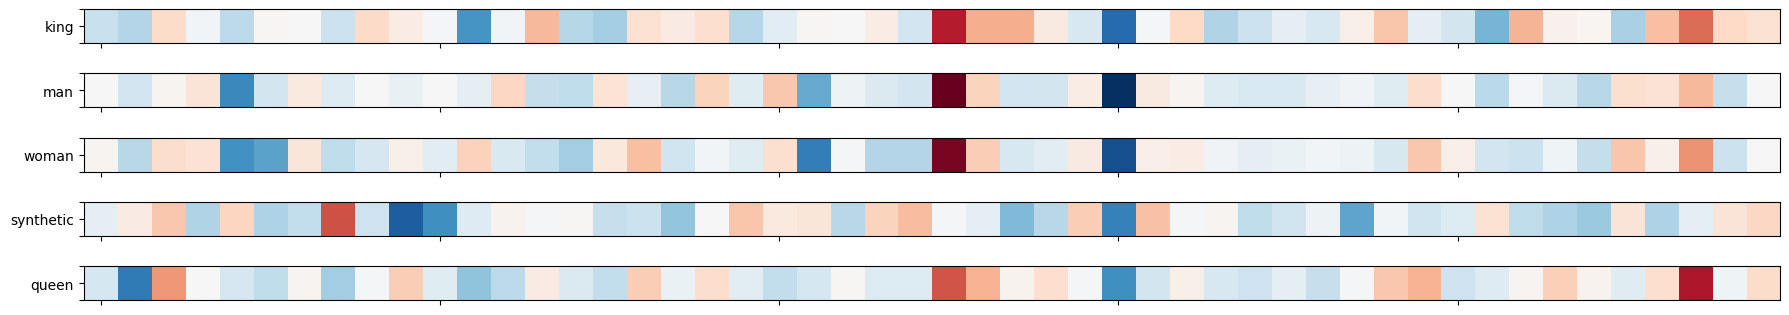

In [84]:
fig = plot_word_vectors(
    glove, ['king', 'man', 'woman', 'synthetic', 'queen'],
    other={'synthetic': synthetic_queen}
)

¿Cómo se parece la "synthetic queen" a la "queen" real? nos podiamos preguntar. Es difícil saberlo sólo mirando los vectores anteriores, pero los vectores de palabras de Gensim tienen un método denominado *similar_by_vector* que
calcula la similitud del coseno entre un vector dado y todo el vocabulario y devuelve las N palabras más similares:

In [85]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738)]

Podemos ver que según este resultado, la palabra más similar a ""synthetic queen" es "queen".

No siempre es así, pero es bastante habitual descubrir que, después de realizar la aritmética de incrustación de palabras, la palabra más similar al resultado es la propia palabra original. 

Por eso, es habitual excluir la palabra original de los resultados de similitud. En este caso, la palabra más parecida a la "synthetic queen" es, en efecto la propia "queen".

Veamos un poco cómo funciona esta aritmética de suma de palabras. La idea general es que las incrustaciones aprendieron a codificar dimensiones abstractas, como "género", "realeza" o "profesión".
abstractas, como "gender", "royalty", "genealogy", or "profession".
Sin embargo, ninguna de estas dimensiones abstractas corresponden a una dimensión numérica simple.

En su gran espacio de características de 50 dimensiones, el modelo aprendió a colocar "man" tan lejos de "woman" como "king" lo está de "queen" (aproximadamente la diferencia de género entre ambos). Del mismo modo, el modelo aprendió a situar "king" tan lejos de "man" como "queen" de "woman" (aproximadamente la diferencia de género entre ambos).

La figura siguiente representa una proyección hipotética en dos dimensiones para facilitar la visualización:

![](figuras/queen.PNG)

De la figura anterior, debería quedar relativamente claro que ambas flechas apuntando hacia arriba (azul) son aproximadamente del mismo tamaño, lo que resulta en la ecuación siguiente:

$$
\Large
w_{\text{king}} - w_{\text{man}}\approx w_{\text{queen}}-w_{\text{woman}} \implies w_{\text{king}} - w_{\text{man}} + w_{\text{woman}} \approx w_{\text{queen}}
$$

Esta aritmética es genial y todo eso, pero no la usarás mucho. ...el punto era mostrarte que las incrustaciones de palabras... de hecho capturan la relación entre diferentes palabras. Podemos usarlas para entrenar otros modelos...

## Usando Word Embeddings

Parece bastante fácil: obtener los corpus de texto tokenizados, buscar los en la tabla de incrustaciones de palabras preentrenadas y, a continuación como entradas de otro modelo. Pero, ¿y si el vocabulario de los corpus no está representado correctamente en las las incrustaciones? Peor aún, ¿y si los pasos de preprocesamiento utilizados han dado lugar a una gran cantidad de tokens que no existen en las incrustaciones?.

Una vez más, el Caballero del Grial tiene razón... la palabra elegida deben proporcionar una buena cobertura de vocabulario. Ante todo la mayoría de los pasos habituales de preprocesamiento no se aplican cuando se usan incrustaciones de palabras preentrenadas como GloVe: ni lematización, ni stemming, ni eliminación de palabras vacías. Estos pasos
acabarían produciendo muchos tokens [UNK].

En segundo lugar, incluso sin esos pasos de preprocesamiento, puede que las palabras utilizadas en los corpus de texto no se ajustan bien a un conjunto determinado de incrustaciones de palabras.

Veamos hasta qué punto las incrustaciones de glove-wiki-gigaword-50 enlazan con nuestro vocabulario. Nuestro vocabulario tiene 3.706 palabras (3.704 de nuestros corpus de texto más el relleno y los tokens especiales desconocidos
desconocidos):

In [86]:
vocab = list(dictionary.token2id.keys())
len(vocab)

3706

Veamos cuántas palabras de nuestro propio vocabulario son desconocidas para las incrustaciones:

In [98]:
#unknown_words = sorted(list(set(vocab).difference(set(glove.vocab))))
# Lo anterior me daba error con la nueva versión 4.0 de Gensim
unknown_words = sorted(list(set(vocab).difference(set(glove.index_to_key))))
print(len(unknown_words))
print(unknown_words[:5])

44
['[PAD]', '[UNK]', 'arrum', 'barrowful', 'beauti']


#glove.vocab
list(glove.index_to_key)

Sólo hay 44 palabras desconocidas: las dos fichas especiales y algunas otras palabras raras como "arrum" y "barrowful". Tiene buena pinta ¿verdad? Significa que hay 3.662 coincidencias de 3.706 palabras, lo que indica una cobertura del 98,81%. Pero en realidad es mejor que eso.

Si nos fijamos en la frecuencia con la que las palabras desconocidas aparecen en nuestros corpus de texto, tendremos una medida precisa de cuántos tokens  serán desconocidas para las incrustaciones. Para obtener el recuento total necesitamos
obtener primero los id de las palabras desconocidas, y luego mirar sus frecuenciasen los corpus:

In [93]:
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ['[PAD]', '[UNK]']]
unknown_count = np.sum([dictionary.cfs[idx] for idx in unknown_ids])
unknown_count, dictionary.num_pos

(82, 50802)

Sólo 82 de las 50.802 palabras de los corpus de texto no pueden emparejarse con el vocabulario de las palabras incrustadas. Un impresionante 99,84% de cobertura.

La siguiente función de ayuda puede utilizarse para calcular la cobertura del vocabulario dado un diccionario de Gensim y unas incrustaciones preentrenados:

In [96]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=('[PAD]', '[UNK]')):
    vocab = list(gensim_dict.token2id.keys())
    unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.index_to_key))))
    unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
    unknown_count = np.sum([gensim_dict.cfs[idx] for idx in unknown_ids])
    cov = 1 - unknown_count / gensim_dict.num_pos
    return cov

In [97]:
# Utilizo la función anterior
vocab_coverage(dictionary, glove)

0.9983858903192788

Cuando estemos satisfechos con la cobertura de vocabulario de nuestras incrustaciones preentrenadas podemos guardar el vocabulario de las incrustaciones en el disco disco como archivo de texto sin formato, para poder utilizarlo con el  HF tokenizer:

In [105]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    words = wv.index_to_key
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, 'vocab.txt'), 'w', encoding="utf-8") as f:
        for word in words:
            f.write(f'{word}\n')   

In [106]:
make_vocab_from_wv(glove, 'glove_vocab/', special_tokens=['[PAD]', '[UNK]'])

Usaremos la clase BertTokenizer una vez más para crear un tokenizador basado en el vocabulario de GloVe:

In [107]:
glove_tokenizer = BertTokenizer('glove_vocab/vocab.txt')

Una vez más: el tokenizador (preentrenado) que utilizará realmente con un modelo BERT (preentrenado) BERT no necesita vocabulario.

Ahora podemos utilizar su método encode para obtener los índices de los tokens de una frase:

In [108]:
glove_tokenizer.encode('alice followed the white rabbit',
add_special_tokens=False)

[7101, 930, 2, 300, 12427]

Estos son los índices que utilizaremos para recuperar las correspondientes incrustaciones de palabras. Hay un pequeño detalle que tenemos que cuidar primero, sin embargo...

<!-- lo dejo en pagina 1203 -->